# Machine Translation + Transformer

<img src = "../figures/transformer1.png" >

In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\Ekkar\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Ekkar\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


cuda


In [2]:
# torch.cuda.get_device_name(0)

In [3]:
torch.__version__

'2.1.1'

In [4]:
torchtext.__version__

'0.16.1+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [5]:
from datasets import load_dataset
dataset = load_dataset('kvush/english_thai_texts')

ENG_LANGUAGE = 'input_text'
THAI_LANGUAGE = 'translated_text'


In [6]:
from datasets import DatasetDict

# Split the dataset manually into train, validation, and test

train_subset = dataset['train'].select(range(41901))   # Select first 70% rows for training

validation_subset = dataset['train'].select(range(41901, 47887))   # Select next 10% rows for validation

test_subset = dataset['train'].select(range(47887, 59859))   # Select next 20% rows for testing

# Create a new DatasetDict with the desired subsets
dataset = DatasetDict({
    'train': train_subset,
    'validation': validation_subset,
    'test': test_subset
})

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_text', 'input_ids', 'translated_text', 'translated_ids', '__index_level_0__'],
        num_rows: 41901
    })
    validation: Dataset({
        features: ['input_text', 'input_ids', 'translated_text', 'translated_ids', '__index_level_0__'],
        num_rows: 5986
    })
    test: Dataset({
        features: ['input_text', 'input_ids', 'translated_text', 'translated_ids', '__index_level_0__'],
        num_rows: 11972
    })
})

In [8]:
train = [(row[ENG_LANGUAGE], row[THAI_LANGUAGE]) for row in dataset['train']]

In [9]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train[0]

('Service, scallops, all - top notch in every way!',
 'บริการหอยเชลล์ทั้งหมด - โดดเด่นในทุกด้าน!')

## 2. EDA - simple investigation

In [10]:
#let's take a look at one example of train
sample = next(iter(train))
sample

('Service, scallops, all - top notch in every way!',
 'บริการหอยเชลล์ทั้งหมด - โดดเด่นในทุกด้าน!')

In [11]:
train_size = len(list(iter(train)))
train_size

41901

In [15]:
val = [(row[ENG_LANGUAGE], row[THAI_LANGUAGE]) for row in dataset['validation']]
test = [(row[ENG_LANGUAGE], row[THAI_LANGUAGE]) for row in dataset['test']]

In [16]:
train_size = len(list(iter(train)))
train_size

41901

In [17]:
val_size = len(list(iter(val)))
val_size

5986

In [18]:
test_size = len(list(iter(test)))
test_size

11972

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [20]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [21]:
# pip install pythainlp

In [22]:
from torchtext.data.utils import get_tokenizer
from pythainlp.tokenize import word_tokenize
token_transform[ENG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[THAI_LANGUAGE] = word_tokenize

In [33]:
torch.save(token_transform, 'token_transform.pth')

In [23]:
sample

('Service, scallops, all - top notch in every way!',
 'บริการหอยเชลล์ทั้งหมด - โดดเด่นในทุกด้าน!')

In [24]:
sample[1]

'บริการหอยเชลล์ทั้งหมด - โดดเด่นในทุกด้าน!'

In [25]:

# Access the English and Thai sentences
english_sentence = sample[0]  # English part
thai_sentence = sample[1]  # Thai part

In [26]:
# Tokenization of English sentence
print("English Sentence: ", english_sentence)
print("English Tokenization: ", token_transform[ENG_LANGUAGE](english_sentence))

English Sentence:  Service, scallops, all - top notch in every way!
English Tokenization:  ['Service', ',', 'scallops', ',', 'all', '-', 'top', 'notch', 'in', 'every', 'way', '!']


In [27]:
# Tokenization of Thai sentence
print("Thai Sentence: ", thai_sentence)
print("Thai Tokenization: ", token_transform[THAI_LANGUAGE](thai_sentence))

Thai Sentence:  บริการหอยเชลล์ทั้งหมด - โดดเด่นในทุกด้าน!
Thai Tokenization:  ['บริการ', 'หอย', 'เชลล์', 'ทั้งหมด', ' ', '-', ' ', 'โดดเด่น', 'ใน', 'ทุก', 'ด้าน', '!']


A function to tokenize our input.

In [29]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {ENG_LANGUAGE: 0, THAI_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [30]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [31]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [ENG_LANGUAGE, THAI_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [ENG_LANGUAGE, THAI_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [32]:
# Save the vocab_transform dictionary
torch.save(vocab_transform, 'vocab_transform.pth')

In [33]:
#see some example
vocab_transform[ENG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[50, 12, 10, 0, 10]

In [34]:
#we can reverse it....
mapping = vocab_transform[ENG_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'haircut'

In [35]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [36]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [37]:
#check unique vocabularies
len(mapping)

16607

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [38]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [ENG_LANGUAGE, THAI_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[ENG_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[THAI_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [39]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [40]:
for en, _, th in train_loader:
    break

In [41]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Thai shape: ", th.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 43])
Thai shape:  torch.Size([64, 58])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [42]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [43]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [44]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim     #size of word embedding
        self.n_heads  = n_heads      #head
        self.head_dim = hid_dim // n_heads   #dk
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale      # from e = s.h   e is att or energy, s is Q(decoder hidden states,  queries), h is K(encoder hidden states, keys)
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0 
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

### Position-wise Feedforward Layer

In [45]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [46]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [47]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [48]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [49]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [50]:
INPUT_DIM = len(vocab_transform[ENG_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[THAI_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [51]:
input_dim   = len(vocab_transform[ENG_LANGUAGE])
output_dim  = len(vocab_transform[THAI_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device)

dec = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(16607, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
  

In [52]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

4251392
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
2985984
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
2985984
 11664
______
14239888


In [53]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [54]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [55]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [56]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [57]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [58]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 1m 45s
	Train Loss: 4.956 | Train PPL: 142.062
	 Val. Loss: 3.899 |  Val. PPL:  49.334
Epoch: 02 | Time: 1m 46s
	Train Loss: 3.429 | Train PPL:  30.858
	 Val. Loss: 2.962 |  Val. PPL:  19.343
Epoch: 03 | Time: 1m 45s
	Train Loss: 2.656 | Train PPL:  14.233
	 Val. Loss: 2.528 |  Val. PPL:  12.532
Epoch: 04 | Time: 1m 46s
	Train Loss: 2.177 | Train PPL:   8.815
	 Val. Loss: 2.312 |  Val. PPL:  10.093
Epoch: 05 | Time: 1m 49s
	Train Loss: 1.845 | Train PPL:   6.327
	 Val. Loss: 2.164 |  Val. PPL:   8.703
Epoch: 06 | Time: 1m 47s
	Train Loss: 1.603 | Train PPL:   4.969
	 Val. Loss: 2.106 |  Val. PPL:   8.212
Epoch: 07 | Time: 1m 47s
	Train Loss: 1.424 | Train PPL:   4.153
	 Val. Loss: 2.082 |  Val. PPL:   8.024
Epoch: 08 | Time: 1m 47s
	Train Loss: 1.274 | Train PPL:   3.574
	 Val. Loss: 2.034 |  Val. PPL:   7.643
Epoch: 09 | Time: 1m 47s
	Train Loss: 1.154 | Train PPL:   3.171
	 Val. Loss: 2.059 |  Val. PPL:   7.839
Epoch: 10 | Time: 1m 48s
	Train Loss: 1.052 | Train PPL

Text(0, 0.5, 'loss')

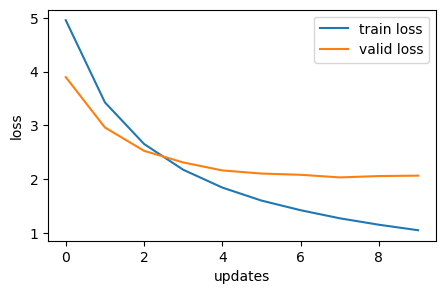

In [59]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [60]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.057 | Test PPL:   7.826 |


## 7. Test on some random news

In [61]:
sample[0]

'Service, scallops, all - top notch in every way!'

In [62]:
sample[1]

'บริการหอยเชลล์ทั้งหมด - โดดเด่นในทุกด้าน!'

In [85]:
src_text = text_transform[ENG_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,  153,    6, 2910,    6,   64,   58,  508, 1441,   19,  250,  219,
          11,    3], device='cuda:0')

In [86]:
trg_text = text_transform[THAI_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,   28, 1352, 2288,  168,    4,  150,    4,  661,   11,  326,  422,
          13,    3], device='cuda:0')

In [87]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [88]:
trg_text = trg_text.reshape(1, -1)

In [89]:
src_text.shape, trg_text.shape

(torch.Size([1, 14]), torch.Size([1, 14]))

In [90]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [91]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [92]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 14, 11664])

Since batch size is 1, we just take off that dimension

In [93]:
output = output.squeeze(0)

In [94]:
output.shape

torch.Size([14, 11664])

We shall remove the first token since it's zeroes anyway

In [95]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([13, 11664])

Then we just take the top token with highest probabilities

In [96]:
output_max = output.argmax(1) #returns max indices

In [97]:
output_max

tensor([1352, 2288,  168,   11,  150,    4,  164,   11,  326,  422,   13,    3,
          13], device='cuda:0')

Get the mapping of the target language

In [98]:
mapping = vocab_transform[THAI_LANGUAGE].get_itos()

In [99]:
for token in output_max:
    print(mapping[token.item()])

หอย
เชลล์
ทั้งหมด
ใน
-
 
สุดยอด
ใน
ทุก
ด้าน
!
<eos>
!


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [100]:
attentions.shape

torch.Size([1, 8, 14, 14])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [101]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([14, 14])

In [102]:
src_tokens = ['<sos>'] + token_transform[ENG_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'Service',
 ',',
 'scallops',
 ',',
 'all',
 '-',
 'top',
 'notch',
 'in',
 'every',
 'way',
 '!',
 '<eos>']

In [103]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'หอย',
 'เชลล์',
 'ทั้งหมด',
 'ใน',
 '-',
 ' ',
 'สุดยอด',
 'ใน',
 'ทุก',
 'ด้าน',
 '!',
 '<eos>',
 '!']

In [83]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\Ekkar\AppData\Local\Temp\ipykernel_32216\59549304.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Ekkar\AppData\Local\Temp\ipykernel_32216\59549304.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)
c:\Users\Ekkar\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3627 (\N{THAI CHARACTER HO HIP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Ekkar\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Ekkar\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Ekkar\anaconda3\lib\site-packages\IPython\core\py

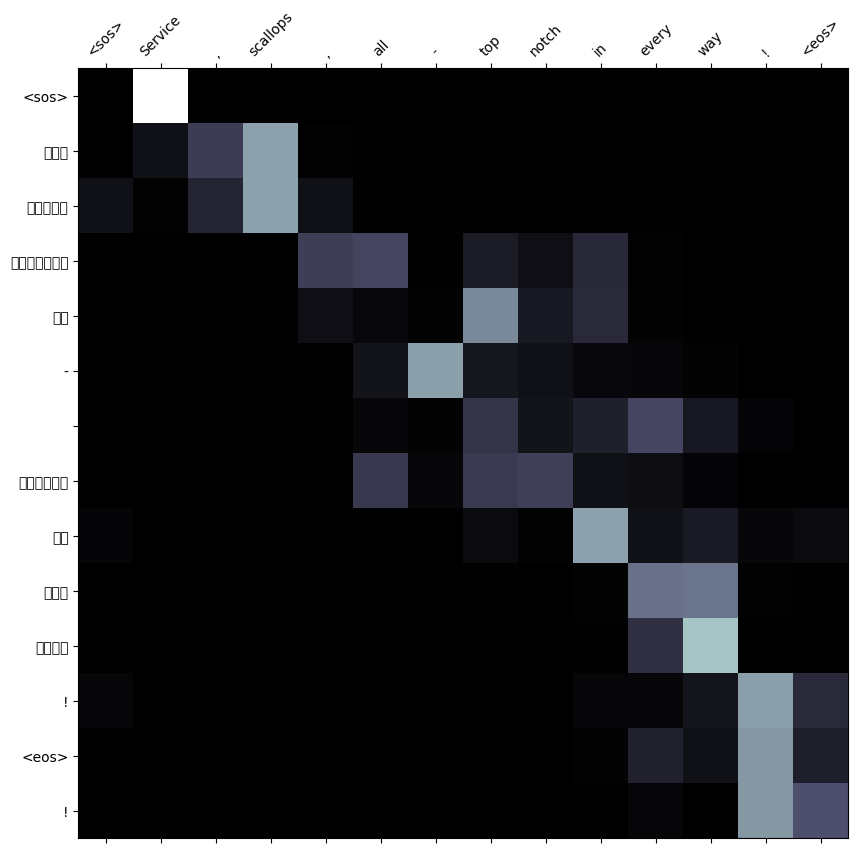

In [84]:
display_attention(src_tokens, trg_tokens, attention)